# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [42]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")


Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [43]:
# Your code here :

from tensorflow.keras.preprocessing.text import Tokenizer

# Step 1: Initialize the tokenizer - Convert text into tokens (unique words) and assign unique integer ID to them
tokenizer = Tokenizer()

# Step 2: Fit the tokenizer on the corpus - map each unique word to a number and build Vocabulary
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [44]:
# Your code here :

# Calculate the vocabulary size
total_words = len(tokenizer.word_index) + 1  # Adding 1 to account for padding or unknown words  

# Print the vocabulary size
print(f"Total Vocabulary Size: {total_words}")

Total Vocabulary Size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [45]:
# Your code here :

# Create an empty list to store input sequences
input_sequences = []

# For each line in the corpus
for line in corpus:
    # Converting the line into seq of integers
    token_list = tokenizer.texts_to_sequences([line])[0] 

    # Generate n-gram sequences
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]  # Take the first 'i' tokens as an n-gram
        input_sequences.append(n_gram_sequence)  # Append to the input_sequences list

# Print the first few input sequences to confirm
print(input_sequences[:5])

[[878], [3], [3, 2], [3, 2, 313], [3, 2, 313, 1375]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [46]:
# Your code here :

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Step 1: Find the length of the longest sequence in input_sequences
max_sequence_len = max([len(seq) for seq in input_sequences])

# Step 2: Pad the sequences to the length of the longest sequence
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Step 3: Convert the result to a numpy array
input_sequences = np.array(input_sequences)

# Print to check
print(f"Max sequence length: {max_sequence_len}")
print(f"Padded sequences shape: {input_sequences.shape}")

Max sequence length: 11
Padded sequences shape: (17805, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [47]:
# Your code here :

# Step 1: Split the sequences into predictors and labels
predictors = input_sequences[:, :-1]  # All elements except the last one
labels = input_sequences[:, -1]       # The last element of each sequence

# Print the shape of predictors and labels to check
print(f"Predictors shape: {predictors.shape}")
print(f"Labels shape: {labels.shape}")


Predictors shape: (17805, 10)
Labels shape: (17805,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [48]:
# Your code here :

from tensorflow.keras.utils import to_categorical

# Step 1: One-hot encode the labels
labels = to_categorical(labels, num_classes=total_words)

# Print to check the shape of the labels
print(f"Labels shape (one-hot encoded): {labels.shape}")


Labels shape (one-hot encoded): (17805, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.regularizers import l2

vocab_size = 3375  # vocabulary size
#max_sequence_len = 11  #  max sequence length

model = Sequential([

    # Your code here :

    # EMBEDDING Layer    
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_len - 1),

    # BIDRECTIONAL LSTM LAYER
    Bidirectional(LSTM(150, return_sequences=True)),

    # DROPOUT Layer
    Dropout(0.2),

    # LSTM Layer
    LSTM(100),

    # DENSE Layer (intermediate)
    Dense(vocab_size // 2, activation='relu', kernel_regularizer=l2(0.01)),

    # DENSE Layer (Output)
    Dense(vocab_size, activation='softmax')
    
])

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [50]:
# Your code here :

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [51]:
# Your code here :

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           337500    
                                                                 
 bidirectional_2 (Bidirecti  (None, 10, 300)           301200    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 10, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1687)              170387    
                                                                 
 dense_5 (Dense)             (None, 3375)              5697000   
                                                      

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [52]:
print(predictors.shape)
print(labels.shape)

(17805, 10)
(17805, 3375)


In [53]:
# Your code here :

# Train the model for 50 epochs/100 epochs
history = model.fit(predictors, labels, epochs=100, batch_size=32, validation_split=0.3)

# Optional: Print the training history keys to explore available metrics
print(history.history.keys())


Epoch 1/100
390/390 [==============================] - 12s 22ms/step - loss: 6.8756 - accuracy: 0.0247 - val_loss: 6.7045 - val_accuracy: 0.0262
Epoch 2/100
390/390 [==============================] - 5s 12ms/step - loss: 6.3969 - accuracy: 0.0277 - val_loss: 6.8551 - val_accuracy: 0.0198
Epoch 3/100
390/390 [==============================] - 4s 11ms/step - loss: 6.3019 - accuracy: 0.0317 - val_loss: 6.9918 - val_accuracy: 0.0300
Epoch 4/100
390/390 [==============================] - 5s 13ms/step - loss: 6.1681 - accuracy: 0.0405 - val_loss: 7.0666 - val_accuracy: 0.0326
Epoch 5/100
390/390 [==============================] - 4s 10ms/step - loss: 6.0478 - accuracy: 0.0449 - val_loss: 7.1928 - val_accuracy: 0.0348
Epoch 6/100
390/390 [==============================] - 4s 12ms/step - loss: 5.9542 - accuracy: 0.0512 - val_loss: 7.2003 - val_accuracy: 0.0393
Epoch 7/100
390/390 [==============================] - 4s 10ms/step - loss: 5.8535 - accuracy: 0.0535 - val_loss: 7.3310 - val_accuracy

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

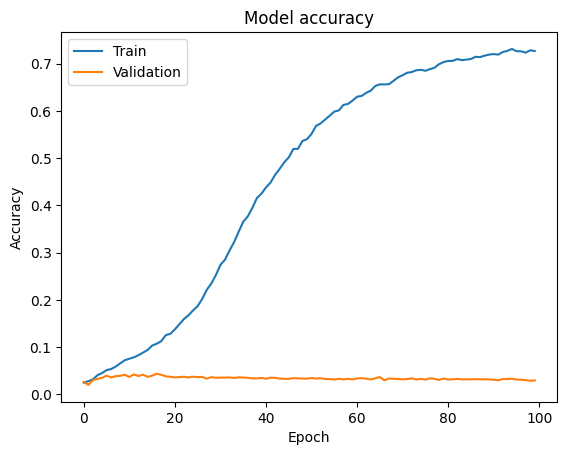

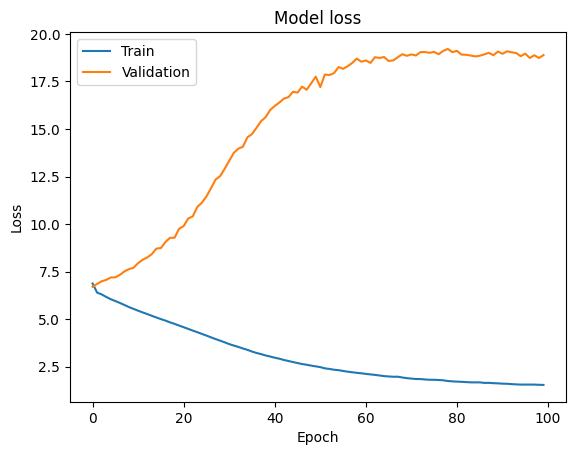

In [54]:
# Your code here :

import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [55]:
# Your code here :

# Seed text (starting point for text generation)
seed_text = "Will Stuttgart win the Champions League?"

# Number of words to generate
next_words = 40  # the number of words to generate

max_sequence_len = 11  # Given value for max sequence length


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [56]:
# Your code here :

import numpy as np

# Create the loop to generate text
def generate_text(model, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        # Tokenize the current seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Ensure token_list is not longer than max_sequence_len - 1
        if len(token_list) > max_sequence_len - 1:
            token_list = token_list[-(max_sequence_len-1):]

        # Pad the sequence so that it matches the input shape of the model
        token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')

        # Predict the next word
        predicted_probs = model.predict(np.array([token_list]), verbose=0)
        predicted_word_index = np.argmax(predicted_probs, axis=-1)[0]

        # Find the word corresponding to the predicted index
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        
        # Append the predicted word to the seed text
        seed_text += " " + output_word

    return seed_text

# Generate text and print the final output
generated_text = generate_text(model, seed_text, next_words, max_sequence_len)
print(generated_text)



Will Stuttgart win the Champions League? is all thy sun were survey survey keep shine pride still buried face ' say done me glory could true fear doth belong forth great clear show thee old other forth life to thee forth it did bring forth thee


Experiment with at least 3 different seed_text strings and see what happens!

In [57]:
# Your code here :

seed_text = "The quick brown fox jumps over the lazy dog in the yard"

# Generate text and print the final output
generated_text = generate_text(model, seed_text, next_words, max_sequence_len)
print(generated_text)



The quick brown fox jumps over the lazy dog in the yard mind pluck esteem dyed dyed held ' shine ' say done me date room dyed dyed ' say scorn die eyes something will mayst give fear doth statues dwell shine say shine bright say afloat buried glory seen me live


In [58]:
# Define the parameters
next_words = 50  # Number of words to generate
max_sequence_len = 11  # Already defined earlier

# Experiment with different seed texts
seed_text_1 = "Shall I compare thee to a summer's day"
seed_text_2 = "The world is full of wonderful things"
seed_text_3 = "To be or not to be that is the question"

# Call the function for each seed text and print the results

# Generate text for seed_text_1
print("Generated text for Seed 1:")
generated_text_1 = generate_text(model, seed_text_1, next_words, max_sequence_len)
print(generated_text_1)

# Generate text for seed_text_2
print("\nGenerated text for Seed 2:")
generated_text_2 = generate_text(model, seed_text_2, next_words, max_sequence_len)
print(generated_text_2)

# Generate text for seed_text_3
print("\nGenerated text for Seed 3:")
generated_text_3 = generate_text(model, seed_text_3, next_words, max_sequence_len)
print(generated_text_3)


Generated text for Seed 1:
Shall I compare thee to a summer's day from other belong shine say remain dyed from me writ it bright contains contains seen me untrue contains contains say fled done me days remain ' say true see unused worth twain twain seen store forth done me ' write arising from thee dyed wrong did live seen it true

Generated text for Seed 2:
The world is full of wonderful things which you buried deeds doth place say ' say friend call shine write of thee it writ it do i fear from me keep keep live are dyed dyed dyed remain bright pride new part doth writ writ it bright do sing so unused fear from sing new prime still

Generated text for Seed 3:
To be or not to be that is the question other in thee abused dyed deem gone say affords make thee seen me decays contains doth done me light dyed ' shine bright bright eyes esteem o'er ere laws down razed o'er wrongs grossly esteem'd gems esteem ' be too cruel air alone crown'd green young deeds of life new
